In [2]:
# Import libraries
import pandas as pd
import datetime as dt
import os
import h5py
import numpy as np
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables
cmap = ctables.registry.get_colortable('precipitation')

In [25]:
# Enter time and Location

start_str = "2020-07-29 12:00:00"
end_str = "2020-07-31 12:00:00"

times_pd = pd.date_range(start=start_str,end=end_str, freq='30min')
times_pd = times_pd[0:-1]
desired_lon = -66.59
desired_lat = 18.22

In [26]:
filepaths = []
for i in times_pd: # Download all the desired IMERG Images
    # If IMERG file does not exist, download it
    
    year = i.year
    day_of_year = i.strftime('%j')
    day_stripped = i.strftime('%Y%m%d')
    time_stripped = i.strftime('%H%M%S')
    min_of_day = str(i.hour*60 + i.minute).zfill(4)
    end_time_stripped = (i+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')
        
    IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
            '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
            '.'+min_of_day+'.V07B.HDF5'  

# If day directory does not exist, make day directory
    if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
        os.mkdir('/Users/acheung/data/IMERG/'+str(year))

    if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
        os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

    if os.path.exists(IMERG_file_path) == False:
        url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
            +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
            '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
        os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + url_desired)
    filepaths.append(IMERG_file_path)


--2024-10-11 05:53:00--  https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S120000-E122959.0720.V07B.HDF5
Resolving gpm1.gesdisc.eosdis.nasa.gov (gpm1.gesdisc.eosdis.nasa.gov)... 198.118.197.50, 2001:4d0:241a:4041::50
Connecting to gpm1.gesdisc.eosdis.nasa.gov (gpm1.gesdisc.eosdis.nasa.gov)|198.118.197.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8058322 (7.7M) [application/x-troff-ms]
Saving to: ‘3B-HHR.MS.MRG.3IMERG.20200729-S120000-E122959.0720.V07B.HDF5’

     0K .......... .......... .......... .......... ..........  0% 8.02M 1s
    50K .......... .......... .......... .......... ..........  1% 23.1M 1s
   100K .......... .......... .......... .......... ..........  1% 21.0M 1s
   150K .......... .......... .......... .......... ..........  2% 30.7M 0s
   200K .......... .......... .......... .......... ..........  3% 45.6M 0s
   250K .......... .......... .......... .......... ..........  3% 23.

In [27]:
for case_loop in range(len(filepaths)): # Run all
# for case_loop in [18]: # Run all
    fn = filepaths[case_loop]
    print(fn)
    try:
        f = h5py.File(fn, 'r')
    except: # If the file is corrupt, remove and re-download
        os.system('rm ' + fn)
        os.chdir(fn[0:35])
        new_url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/' + fn[26:]
        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + new_url)
        f = h5py.File(fn, 'r')
        
    # Work on precip file
    groups = [ x for x in f.keys() ]
    # print(groups)
    gridMembers = [ x for x in f['Grid'] ]
    # print(gridMembers)

    # Get the precipitation, latitude, and longitude variables
    precip = f['Grid/precipitation'][0][:][:]
    precip = np.transpose(precip)
    precip[precip<-999]=np.nan

    theLats = f['Grid/lat'][:]
    theLons = f['Grid/lon'][:]
    x, y = np.float32(np.meshgrid(theLons, theLats))

    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x, y,(desired_lon,desired_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))
    
    # Slice arrays to within 100 indices of interpolated best-track center

    sliced_lon_grid = x[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    sliced_lat_grid = y[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    sliced_precip = precip[min_dist_ind[0][0]-30:min_dist_ind[0][0]+30,min_dist_ind[1][0]-30:min_dist_ind[1][0]+30]

    if case_loop == 0:
        total_precip = sliced_precip * 0.5
    else:
        total_precip = total_precip + (sliced_precip * 0.5)

/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S120000-E122959.0720.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S123000-E125959.0750.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S130000-E132959.0780.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S133000-E135959.0810.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S140000-E142959.0840.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S143000-E145959.0870.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S150000-E152959.0900.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S153000-E155959.0930.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S160000-E162959.0960.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HHR.MS.MRG.3IMERG.20200729-S163000-E165959.0990.V07B.HDF5
/Users/acheung/data/IMERG/2020/211/3B-HH

Text(0.5, 1.0, 'start = 2020-07-29 12:00:00, end = 2020-07-31 12:00:00')

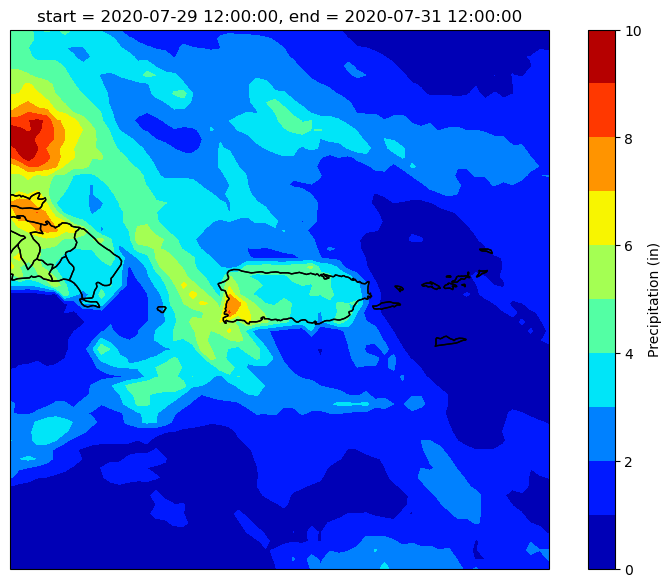

In [30]:
# Make the figure larger
fig = plt.figure(figsize=(10,7))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())
clevs=[0.01,0.10,0.25,0.5,1,1.5,2,3,4,5,6,7,8,10,12,14,16,18,20,24,28,32,36,40]
imerg_plot = ax.contourf(sliced_lon_grid,sliced_lat_grid,total_precip/25.4,
            transform = ccrs.PlateCarree(),levels=np.arange(0,10.1,1),cmap='jet') # Convert units from mm to inches by dividing

# Add coastlines
# ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(imerg_plot,label='Precipitation (in)')
plt.title('start = ' + start_str + ', end = ' + end_str)
